# Simulation example using Area Yield DGP

In [1]:
import numpy as np
import pandas as pd
import warnings
from tqdm import tqdm
from IPython.display import clear_output

from sklearn.ensemble import StackingRegressor, StackingClassifier
from sklearn.linear_model import RidgeCV
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

from rdrobust import rdrobust, rdbwselect

import doubleml as dml
from doubleml.utils import GlobalRegressor, GlobalClassifier
from doubleml.rdd import RDFlex
from doubleml.rdd import datasets

from matplotlib import pyplot as plt
from statsmodels.nonparametric.kernel_regression import KernelReg

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%run utils.py

## DGP Parameters

In [3]:
cutoff_dist = 0.45
cutoff_improvement = 0.0

params = dict(
    seed=17,
    n_obs=3,
    K=100,
    # origin
    origin_shape='ellipsis',
    origin_a=0.035,
    origin_b=0.01,
    origin_pertubation=0.2,
    # target
    target_center=[1.5, 0],
    target_a=0.6,
    target_b=0.3,
    # action
    action_shift=[1.0, 0],
    action_scale=1.02,
    #action_pertubation=None,
    action_pertubation=[0.001, 0.0006],
    action_drag_share=0.7,
    action_drag_scale=0.7,
    # running
    running_dist_measure='projected',
    running_mea_selection=5,
    # treatment
    treatment_dist=cutoff_dist,
    treatment_improvement=cutoff_improvement,
    treatment_random_share=0.0,
    improvement_noise_scale=0.03,
    improvement_noise_loc=-0.01,
)

## DGP Visualization

In [4]:
data = datasets.dgp_area_yield(**{**params, 'n_obs': 5000, 'seed': 8})

# improved_points = data['score_improvement'] >= 0.0
# data = {k:v[improved_points] for k,v in data.items()}

fig = px.scatter(x=data['score_distance'] ,y=data['Y'], color=data['D'], labels=dict(x="score_distance", y="Y"), hover_data={'score_improvement': data['score_improvement'], 'score_distance_act': data['score_distance_act'], 'score_improvement_act': data['score_improvement_act']}) 
fig.add_vline(x=params['treatment_dist'])

In [5]:
fig = px.scatter(x=data['score_distance'] ,y=data['score_improvement'], color=data['D'], labels=dict(x="score_distance", y="score_improvement"), hover_data={'score_improvement': data['score_improvement'], 'score_distance_act': data['score_distance_act'], 'score_improvement_act': data['score_improvement_act']}) 
fig.add_vline(x=params['treatment_dist'])
fig.add_hline(y=cutoff_improvement)

In [6]:
fig = px.scatter(x=data['score_improvement'] ,y=data['Y1'] - data['Y0'], color=data['D'], labels=dict(x="score_improvement", y="effect"), hover_data={'score_improvement': data['score_improvement'], 'score_distance_act': data['score_distance_act'], 'score_improvement_act': data['score_improvement_act']}) 
fig.add_vline(x=params['treatment_improvement'])

In [7]:
fig = px.scatter(x=data['score_distance'] ,y=data['Y1'] - data['Y0'], color=data['D'], labels=dict(x="score_distance", y="effect"), hover_data={'score_improvement': data['score_improvement'], 'score_distance_act': data['score_distance_act'], 'score_improvement_act': data['score_improvement_act']}) 
fig.add_vline(x=params['treatment_dist'])

## Oracle / Neighborhood Estimator
Estimation is done using bigger sample

In [8]:
n_obs = 10000
selected_params = {**params, 'n_obs': n_obs}
data = datasets.dgp_area_yield(**selected_params)

defiers = data["D"] != data["T"]
print(f"Defier percentage: {defiers.mean()}")
compliers = data["D"] == data["T"]
print(f"Complier percentage: {compliers.mean()}")

defiers_distance_right = (data["D"] == 0) & (data["score_distance"] >= params['treatment_dist'])
defiers_distance_left = (data["D"] == 1) & (data["score_distance"] < params['treatment_dist'])
defiers_distance = defiers_distance_right | defiers_distance_left
print(f"Defier distance percentage: {defiers_distance.mean()}")

compliers_distance_right = (data["D"] == 1) & (data["score_distance"] >= params['treatment_dist'])
compliers_distance_left = (data["D"] == 0) & (data["score_distance"] < params['treatment_dist'])
compliers_distance = compliers_distance_right | compliers_distance_left
print(f"Complier distance percentage: {compliers_distance.mean()}")

Defier percentage: 0.019
Complier percentage: 0.981
Defier distance percentage: 0.0136
Complier distance percentage: 0.9864


In [9]:
cutoff = params['treatment_dist']
score = data['score_distance']
ite = data['Y1'] - data['Y0']

kernel_regression_range = 0.3
# remove defiers and restrict to a range around the cutoff
kernel_subset = (score >= cutoff - kernel_regression_range) & (score <= cutoff + kernel_regression_range)

Define all oracle effects

In [10]:
# effect at cutoff
kernel_reg = KernelReg(endog=ite[kernel_subset], exog=score[kernel_subset], var_type='c', reg_type='ll')

effect, _  = kernel_reg.fit(np.array([cutoff]))
effect_kernel = effect[0]
print(f"Estimated effect at cutoff (all): {effect_kernel}")

# fuzzy effect
kernel_subset_fuzzy = kernel_subset & compliers_distance
kernel_reg_fuzzy = KernelReg(endog=ite[kernel_subset_fuzzy], exog=score[kernel_subset_fuzzy], var_type='c', reg_type='ll')

effect_fuzzy, _  = kernel_reg_fuzzy.fit(np.array([cutoff]))
effect_fuzzy_kernel = effect_fuzzy[0]
print(f"Estimated effect at cutoff (fuzzy/compliers): {effect_fuzzy_kernel}")

# intention to treat
ite_intend = data['Y1'] - data['Y0']
if any (defiers_distance_left):
    ite_intend[defiers_distance_left] = data['Y0'] - data['Y1'] # react inverse to treatment assignment
if any (defiers_distance_right):
    ite_intend[defiers_distance_right] = 0 # do not react to treatment assignment

kernel_reg_intend = KernelReg(endog=ite_intend[kernel_subset], exog=score[kernel_subset], var_type='c', reg_type='ll')

effect_intend, _  = kernel_reg_intend.fit(np.array([cutoff]))
effect_intend_kernel = effect_intend[0]
print(f"Estimated effect at cutoff (intend to treat): {effect_intend_kernel}")

Estimated effect at cutoff (all): 0.07436468795371451
Estimated effect at cutoff (fuzzy/compliers): 0.10618359318585868
Estimated effect at cutoff (intend to treat): 0.06636199040202831


In [11]:
treatment_dist = params['treatment_dist']
X1_close = (score[kernel_subset] > treatment_dist - 0.02) & (score[kernel_subset] < treatment_dist + 0.02)
X1_close_fuzzy = (score[kernel_subset_fuzzy] > treatment_dist - 0.02) & (score[kernel_subset_fuzzy] < treatment_dist + 0.02)

print(f'Neighborhood observations: {X1_close.sum()}')
effect_neighborhood = ite[kernel_subset][X1_close].mean()
print(f'Neighborhood estimator: {effect_neighborhood}')

print(f'Neighborhood observations (fuzzy): {X1_close_fuzzy.sum()}')
effect_fuzzy_neighborhood = ite[kernel_subset_fuzzy][X1_close_fuzzy].mean()
print(f'Neighborhood estimator (fuzzy): {effect_fuzzy_neighborhood}')

print(f'Neighborhood observations (intend to treat): {X1_close.sum()}')
effect_intend_neighborhood = ite_intend[kernel_subset][X1_close].mean()
print(f'Neighborhood estimator (intend to treat): {effect_intend_neighborhood}')

Neighborhood observations: 209
Neighborhood estimator: 0.0783732057416268
Neighborhood observations (fuzzy): 149
Neighborhood estimator (fuzzy): 0.09604026845637582
Neighborhood observations (intend to treat): 209
Neighborhood estimator (intend to treat): 0.0684688995215311


In [12]:
treatment_status = np.where(data['D'][kernel_subset][X1_close], "treated", "control")
treatment_status[defiers_distance[kernel_subset][X1_close]] = "defier"

fig = make_subplots(rows=1, cols=2, subplot_titles=("Effect", "Intend-to-treat"))

# First scatter plot (Effect)
fig_1 = px.scatter(x=data['score_distance'][kernel_subset][X1_close],
                   y=ite[kernel_subset][X1_close],
                   color=treatment_status,
                   labels={'x': "Score Distance", 'y': "Effect"})

# Add traces from the first plot to the first subplot (with legend)
for trace in fig_1.data:
    fig.add_trace(trace, row=1, col=1)


# Second scatter plot (Intend-to-treat)
fig_2 = px.scatter(x=data['score_distance'][kernel_subset][X1_close],
                   y=ite_intend[kernel_subset][X1_close],
                   color=treatment_status,
                   labels={'x': "Score Distance", 'y': "Effect (intend-to-treat)"})

# Add traces from the second plot to the second subplot (hide legend)
for trace in fig_2.data:
    trace.showlegend = False
    fig.add_trace(trace, row=1, col=2)

# Add vertical lines (Treatment Dist)
fig.add_vline(x=params['treatment_dist'], line_width=2, line_dash="dash", line_color="red",
              annotation_text="Treatment Dist", annotation_position="top left", row=1, col=1)
fig.add_vline(x=params['treatment_dist'], line_width=2, line_dash="dash", line_color="red",
              annotation_text="Treatment Dist", annotation_position="top left", row=1, col=2)

# Add horizontal lines (Effect Means)
fig.add_hline(y=effect_neighborhood, line_width=2, line_dash="dash", line_color="blue",
              annotation_text=f"Neighborhood Mean: {effect_neighborhood:.2f}", annotation_position="top right", row=1, col=1)
fig.add_hline(y=effect_fuzzy_neighborhood, line_width=2, line_dash="dash", line_color="purple",
                annotation_text=f"Fuzzy Mean: {effect_fuzzy_neighborhood:.2f}", annotation_position="top right", row=1, col=1)
fig.add_hline(y=effect_intend_neighborhood, line_width=2, line_dash="dash", line_color="green",
              annotation_text=f"Intend Mean: {effect_intend_neighborhood:.2f}", annotation_position="top right", row=1, col=2)

# Update layout for the entire figure (legend will only appear for fig_1)
fig.update_layout(title_text="Effect and Intend-to-Treat", showlegend=True)
# add axis labels
fig.update_xaxes(title_text="Distance Score", row=1, col=1)
fig.update_xaxes(title_text="Distance Score", row=1, col=2)
fig.update_yaxes(title_text="Effect", row=1, col=1)

# Show figure
fig.show()


## Learners

In [13]:
base_regressors = [
    ('lgbm_regressor', LGBMRegressor(n_estimators=200, learning_rate=0.01, verbose=-1, n_jobs=-1)),
    ('linear_regressor', LinearRegression()),
    ('global_regressor', GlobalRegressor(LinearRegression())),
]

stacking_regressor = StackingRegressor(
    estimators=base_regressors,
    final_estimator=LinearRegression(),
    n_jobs=-1
)

base_classifiers = [
    ('lgbm_classifier', LGBMClassifier(n_estimators=200, learning_rate=0.01, verbose=-1, n_jobs=-1)),
    ('logistic_classifier', LogisticRegression()),
    ('global_classifier', GlobalClassifier(LogisticRegression())),
]

stacking_classifier = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=LogisticRegression(),
    n_jobs=-1
)

In [14]:
linear_learner_dict = {
    "regressor": LinearRegression(),
    "classifier": LogisticRegression(),
}

global_linear_learner_dict = {
    "regressor": GlobalRegressor(LinearRegression()),
    "classifier": GlobalClassifier(LogisticRegression()),
}

lgbm_learner_dict = {
    "regressor": LGBMRegressor(n_estimators=500, learning_rate=0.01, verbose=-1, n_jobs=-1),
    "classifier": LGBMClassifier(n_estimators=500, learning_rate=0.01, verbose=-1, n_jobs=-1),
}

stacking_learner_dict = {
    "regressor": stacking_regressor,
    "classifier": stacking_classifier,
}


In [15]:
learner_dict = {
    "linear": linear_learner_dict,
    "global_linear": global_linear_learner_dict,
    "lgbm": lgbm_learner_dict,
    "stacking_regressor": stacking_learner_dict,
}

## Simulation

### Single replication

In [16]:
from scipy.stats import skew, kurtosis

In [17]:
def generate_data(seed, n_obs=1000):
    # generate data
    selected_params = {**params, 'n_obs': n_obs, 'seed': seed}
    data = datasets.dgp_area_yield(**selected_params)
    score = data["score_distance"]
    Y = data["Y"]
    D = data["D"]

    # Replace X with non score-related parameters
    # TODO: Maybe add range or offset from conversion curve
    mean_values = np.mean(data["X"], axis=1)
    min_values = np.min(data["X"], axis=1)
    max_values = np.max(data["X"], axis=1)
    std_values = np.std(data["X"], axis=1)
    skewness_values = skew(data["X"], axis=1)
    kurtosis_values = kurtosis(data["X"], axis=1)

    X = np.column_stack((mean_values, min_values, max_values, std_values, skewness_values, kurtosis_values))
    # X = data["X"][:, :-1, :].reshape(n_obs, -1)
    # X = data["X"].reshape(n_obs, -1)

    data_dict = {
        "X": X,
        "D": D,
        "Y": Y,
        "score": score,
    }
    return data_dict

def estimate_fuzzy(seed, data_dict, learner_dict, fs_specifications, kernels, cutoff=0):
    coef_types = ["Conventional", "Bias-Corrected", "Robust"]
    res_list_fuzzy = []
    
    # run basic rdrobust
    for kernel in kernels:
        try:
            res_fuzzy = rdrobust(y=data_dict["Y"], x=data_dict["score"], fuzzy=data_dict["D"], covs=data_dict["X"], c=cutoff, kernel=kernel)
            h=None
        except Exception as e:
            print(f"Error in rdrobust bandwidth: {e}")
            h = rdbwselect(y=data_dict["Y"],
                x=data_dict["score"],
                fuzzy=data_dict["D"],
                c=cutoff,
                sharpbw=True).bws.values.flatten().max()
            res_fuzzy = rdrobust(y=data_dict["Y"], x=data_dict["score"], fuzzy=data_dict["D"], covs=data_dict["X"], c=cutoff, h=h)

        specification_dict = {"rep": seed, "method": "rdrobust", "learner": "linear",
            "orcl": effect_fuzzy_kernel, "orcl_neigh": effect_fuzzy_neighborhood,
            "fs_specification": "cutoff", "kernel": kernel}

        coef_dict = {f"coef_{coef_type}": res_fuzzy.coef.loc[coef_type, "Coeff"] for coef_type in coef_types}
        se_dict = {f"se_{coef_type}": res_fuzzy.se.loc[coef_type, "Std. Err."] for coef_type in coef_types}
        ci_lower_dict = {f"lower_ci_{coef_type}": res_fuzzy.ci.loc[coef_type, "CI Lower"] for coef_type in coef_types}
        ci_upper_dict = {f"upper_ci_{coef_type}": res_fuzzy.ci.loc[coef_type, "CI Upper"] for coef_type in coef_types}
        
        res_list_fuzzy.append(
            {**specification_dict, **coef_dict, **se_dict, **ci_lower_dict, **ci_upper_dict})

    # RDFlex methods
    dml_data = dml.DoubleMLData.from_arrays(y=data_dict["Y"], d=data_dict["D"], x=data_dict["X"], s=data_dict["score"])

    for learner_name, learners in learner_dict.items():
        for fs_specification in fs_specifications:
            for kernel in kernels:
                rdflex_model_fuzzy = RDFlex(dml_data,
                                            ml_g=learners["regressor"],
                                            ml_m=learners["classifier"],
                                            n_folds=5,
                                            n_rep=1,
                                            cutoff=cutoff,
                                            fuzzy=True,
                                            fs_specification=fs_specification,
                                            h_fs=h,
                                            kernel=kernel)
                rdflex_model_fuzzy.fit(n_iterations=2)

                specification_dict = {"rep": seed, "method": "rdflex", "learner": learner_name,
                    "orcl": effect_fuzzy_kernel, "orcl_neigh": effect_fuzzy_neighborhood,
                    "fs_specification": "cutoff", "kernel": kernel}

                coef_dict = {f"coef_{coef_type}": rdflex_model_fuzzy.coef[i] for i, coef_type in enumerate(coef_types)}
                se_dict = {f"se_{coef_type}": rdflex_model_fuzzy.se[2] for i, coef_type in enumerate(coef_types)}
                ci_lower_dict = {f"lower_ci_{coef_type}": rdflex_model_fuzzy.confint().loc[coef_type, "2.5 %"] for coef_type in coef_types}
                ci_upper_dict = {f"upper_ci_{coef_type}": rdflex_model_fuzzy.confint().loc[coef_type, "97.5 %"] for coef_type in coef_types}

                res_list_fuzzy.append(
                    {**specification_dict, **coef_dict, **se_dict, **ci_lower_dict, **ci_upper_dict})
    return res_list_fuzzy


def estimate_indend(seed, data_dict, learner_dict, fs_specifications, kernels, cutoff=0):
    coef_types = ["Conventional", "Bias-Corrected", "Robust"]
    res_list_intend = []
    for kernel in kernels:
        res_intend = rdrobust(y=data_dict["Y"], x=data_dict["score"], covs=data_dict["X"], c=cutoff, kernel=kernel)
        specification_dict = {"rep": seed, "method": "rdrobust", "learner": "linear",
            "orcl": effect_intend_kernel, "orcl_neigh": effect_intend_neighborhood,
            "fs_specification": "cutoff", "kernel": kernel}

        coef_dict = {f"coef_{coef_type}": res_intend.coef.loc[coef_type, "Coeff"] for coef_type in coef_types}
        se_dict = {f"se_{coef_type}": res_intend.se.loc[coef_type, "Std. Err."] for coef_type in coef_types}
        ci_lower_dict = {f"lower_ci_{coef_type}": res_intend.ci.loc[coef_type, "CI Lower"] for coef_type in coef_types}
        ci_upper_dict = {f"upper_ci_{coef_type}": res_intend.ci.loc[coef_type, "CI Upper"] for coef_type in coef_types}

        res_list_intend.append(
            {**specification_dict, **coef_dict, **se_dict, **ci_lower_dict, **ci_upper_dict})
    
    # RDFlex methods
    dml_data = dml.DoubleMLData.from_arrays(y=data_dict["Y"], d=data_dict["D"], x=data_dict["X"], s=data_dict["score"])

    for learner_name, learners in learner_dict.items():
        for fs_specification in fs_specifications:
            for kernel in kernels:
                rdflex_model_intend = RDFlex(dml_data,
                                            ml_g=learners["regressor"],
                                            n_folds=5,
                                            n_rep=1,
                                            cutoff=cutoff,
                                            fuzzy=False,
                                            fs_specification=fs_specification,
                                            kernel=kernel)
                rdflex_model_intend.fit(n_iterations=2)

                specification_dict = {"rep": seed, "method": "rdflex", "learner": learner_name,
                    "orcl": effect_intend_kernel, "orcl_neigh": effect_intend_neighborhood,
                    "fs_specification": "cutoff", "kernel": kernel}
                
                coef_dict = {f"coef_{coef_type}": rdflex_model_intend.coef[i] for i, coef_type in enumerate(coef_types)}
                se_dict = {f"se_{coef_type}": rdflex_model_intend.se[2] for i, coef_type in enumerate(coef_types)}
                ci_lower_dict = {f"lower_ci_{coef_type}": rdflex_model_intend.confint().loc[coef_type, "2.5 %"] for coef_type in coef_types}
                ci_upper_dict = {f"upper_ci_{coef_type}": rdflex_model_intend.confint().loc[coef_type, "97.5 %"] for coef_type in coef_types}

                res_list_intend.append({**specification_dict, **coef_dict, **se_dict, **ci_lower_dict, **ci_upper_dict})
    
    return res_list_intend

In [18]:
n_rep = 1
n_obs = 5000
fs_specifications = ["cutoff"]
kernels = ["uniform", "triangular", "epanechnikov"]

res_list_fuzzy = []
res_list_intend = []
for r in tqdm(range(n_rep), desc="Repetitions", unit="rep"):

    data_dict = generate_data(r, n_obs=n_obs)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # Fuzzy RDD
        try:
            single_res_fuzzy = estimate_fuzzy(
                r,
                data_dict,
                learner_dict=learner_dict,
                fs_specifications=fs_specifications,
                kernels=kernels,
                cutoff=cutoff)
            res_list_fuzzy.extend(single_res_fuzzy)
        except Exception as e:
                print(f"An error occurred during fuzzy repetition {r}: {e}")

        # Intention to treat RDD
        try:
            single_res_intend = estimate_indend(
                r,
                data_dict,
                learner_dict=learner_dict,
                fs_specifications=fs_specifications,
                kernels=kernels,
                cutoff=cutoff)
            res_list_intend.extend(single_res_intend)
        except Exception as e:
                print(f"An error occurred during intend repetition {r}: {e}")

df_fuzzy_single = pd.DataFrame(res_list_fuzzy)
df_intend_single = pd.DataFrame(res_list_intend)

Repetitions: 100%|██████████| 1/1 [03:11<00:00, 191.61s/rep]


In [19]:
df_fuzzy_single.head(n=10)

,rep,method,learner,orcl,orcl_neigh,fs_specification,kernel,coef_Conventional,coef_Bias-Corrected,coef_Robust,se_Conventional,se_Bias-Corrected,se_Robust,lower_ci_Conventional,lower_ci_Bias-Corrected,lower_ci_Robust,upper_ci_Conventional,upper_ci_Bias-Corrected,upper_ci_Robust
0,0,rdrobust,linear,0.106184,0.09604,cutoff,uniform,0.053981,0.057692,0.057692,0.009921,0.009921,0.011912,0.034537,0.038248,0.034345,0.073425,0.077136,0.081039
1,0,rdrobust,linear,0.106184,0.09604,cutoff,triangular,0.122403,0.140840,0.140840,0.019243,0.019243,0.021384,0.084686,0.103123,0.098929,0.160119,0.178556,0.182751
2,0,rdrobust,linear,0.106184,0.09604,cutoff,epanechnikov,0.101067,0.117190,0.117190,0.017077,0.017077,0.019352,0.067596,0.083719,0.079262,0.134538,0.150661,0.155118
3,0,rdflex,linear,0.106184,0.09604,cutoff,uniform,0.131103,0.141000,0.141000,0.025023,0.025023,0.025023,0.084409,0.094307,0.091957,0.177796,0.187694,0.190044
4,0,rdflex,linear,0.106184,0.09604,cutoff,triangular,0.139022,0.153314,0.153314,0.024965,0.024965,0.024965,0.093375,0.107667,0.104385,0.184670,0.198961,0.202244
5,0,rdflex,linear,0.106184,0.09604,cutoff,epanechnikov,0.138420,0.154779,0.154779,0.026017,0.026017,0.026017,0.091088,0.107447,0.103788,0.185752,0.202111,0.205770
6,0,rdflex,global_linear,0.106184,0.09604,cutoff,uniform,0.123232,0.135712,0.135712,0.027644,0.027644,0.027644,0.072057,0.084537,0.081530,0.174407,0.186887,0.189894
7,0,rdflex,global_linear,0.106184,0.09604,cutoff,triangular,0.138649,0.153807,0.153807,0.027146,0.027146,0.027146,0.089314,0.104471,0.100601,0.187985,0.203142,0.207013
8,0,rdflex,global_linear,0.106184,0.09604,cutoff,epanechnikov,0.144709,0.163941,0.163941,0.028882,0.028882,0.028882,0.092685,0.111917,0.107332,0.196733,0.215965,0.220549
9,0,rdflex,lgbm,0.106184,0.09604,cutoff,uniform,0.086591,0.088228,0.088228,0.022971,0.022971,0.022971,0.048354,0.049991,0.043206,0.124828,0.126465,0.133251


In [20]:
df_intend_single.head(n=10)

,rep,method,learner,orcl,orcl_neigh,fs_specification,kernel,coef_Conventional,coef_Bias-Corrected,coef_Robust,se_Conventional,se_Bias-Corrected,se_Robust,lower_ci_Conventional,lower_ci_Bias-Corrected,lower_ci_Robust,upper_ci_Conventional,upper_ci_Bias-Corrected,upper_ci_Robust
0,0,rdrobust,linear,0.066362,0.068469,cutoff,uniform,0.038765,0.038287,0.038287,0.007499,0.007499,0.008993,0.024067,0.023588,0.020661,0.053464,0.052985,0.055912
1,0,rdrobust,linear,0.066362,0.068469,cutoff,triangular,0.066431,0.072251,0.072251,0.011266,0.011266,0.012488,0.044350,0.050170,0.047774,0.088511,0.094331,0.096728
2,0,rdrobust,linear,0.066362,0.068469,cutoff,epanechnikov,0.057509,0.062335,0.062335,0.010486,0.010486,0.011840,0.036956,0.041782,0.039129,0.078062,0.082888,0.085541
3,0,rdflex,linear,0.066362,0.068469,cutoff,uniform,0.036865,0.037057,0.037057,0.009701,0.009701,0.009701,0.021162,0.021354,0.018043,0.052569,0.052761,0.056072
4,0,rdflex,linear,0.066362,0.068469,cutoff,triangular,0.067994,0.074299,0.074299,0.012877,0.012877,0.012877,0.045222,0.051527,0.049061,0.090767,0.097071,0.099537
5,0,rdflex,linear,0.066362,0.068469,cutoff,epanechnikov,0.064365,0.070208,0.070208,0.012811,0.012811,0.012811,0.041836,0.047679,0.045099,0.086894,0.092737,0.095316
6,0,rdflex,global_linear,0.066362,0.068469,cutoff,uniform,0.038176,0.038073,0.038073,0.009664,0.009664,0.009664,0.022578,0.022475,0.019131,0.053773,0.053670,0.057014
7,0,rdflex,global_linear,0.066362,0.068469,cutoff,triangular,0.061983,0.067417,0.067417,0.012964,0.012964,0.012964,0.039267,0.044701,0.042008,0.084699,0.090133,0.092826
8,0,rdflex,global_linear,0.066362,0.068469,cutoff,epanechnikov,0.056532,0.061332,0.061332,0.012453,0.012453,0.012453,0.034993,0.039792,0.036924,0.078072,0.082872,0.085740
9,0,rdflex,lgbm,0.066362,0.068469,cutoff,uniform,0.037989,0.036302,0.036302,0.012003,0.012003,0.012003,0.016954,0.015267,0.012777,0.059025,0.057338,0.059828


In [21]:
def plot_ci(df):
    coef_types = ["Conventional", "Bias-Corrected", "Robust"]
    kernels = df["kernel"].unique()
    df["method_and_learner"] = df["method"] + "_" + df["learner"]
    
    # Create a mapping of unique method_and_learner combinations to fixed, evenly spaced jitter values
    unique_combinations = df["method_and_learner"].unique()
    jitter_values = np.linspace(-0.2, 0.2, len(unique_combinations))
    jitter_mapping = {method_learner: jitter for method_learner, jitter in zip(unique_combinations, jitter_values)}

    # Create a color palette and assign colors to each unique method_and_learner
    palette = sns.color_palette("husl", len(unique_combinations))
    color_mapping = {method_learner: color for method_learner, color in zip(unique_combinations, palette)}

    # Create a figure with subplots arranged in a single column, sharing the same y-axis
    fig, axes = plt.subplots(len(kernels), 1, figsize=(12, 4 * len(kernels)), sharex=True, sharey=True)
    
    if len(kernels) == 1:
        axes = [axes]  # Ensure axes is iterable if there's only one kernel

    for ax, kernel in zip(axes, kernels):
        subset_kernel = df[df["kernel"] == kernel]
        
        for method_learner in subset_kernel["method_and_learner"].unique():
            subset = subset_kernel[subset_kernel["method_and_learner"] == method_learner]
            
            for i, coef_type in enumerate(coef_types):
                coefs = subset[f"coef_{coef_type}"]
                ci_lower = subset[f"lower_ci_{coef_type}"]
                ci_upper = subset[f"upper_ci_{coef_type}"]

                # Use fixed jitter values
                x_jittered = np.full(len(coefs), i) + jitter_mapping[method_learner]

                ax.errorbar(x=x_jittered, y=coefs, yerr=[coefs - ci_lower, ci_upper - coefs], fmt='o', capsize=5, label=method_learner if i == 0 else "", color=color_mapping[method_learner])
        
        # Add a dashed red horizontal line at df["orcl"]
        orcl_value = subset_kernel["orcl"].iloc[0]  # Assuming 'orcl' is the same for all rows in the subset
        ax.axhline(y=orcl_value, color='red', linestyle='--', linewidth=1, label='ORCL' if kernel == kernels[0] else "")
        
        ax.set_xticks(np.arange(len(coef_types)))
        ax.set_xticklabels(coef_types)
        ax.set_xlabel('Coefficient Type')
        ax.set_ylabel('Coefficient')
        ax.set_title(f'Coefficients with Confidence Intervals for Kernel: {kernel}')
        ax.grid(True)
    
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.tight_layout()
    plt.show()

c:\Users\svenk\anaconda3\envs\dml_rdd\Lib\site-packages\matplotlib\cbook.py:1762: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

c:\Users\svenk\anaconda3\envs\dml_rdd\Lib\site-packages\matplotlib\cbook.py:1762: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

c:\Users\svenk\anaconda3\envs\dml_rdd\Lib\site-packages\matplotlib\cbook.py:1762: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



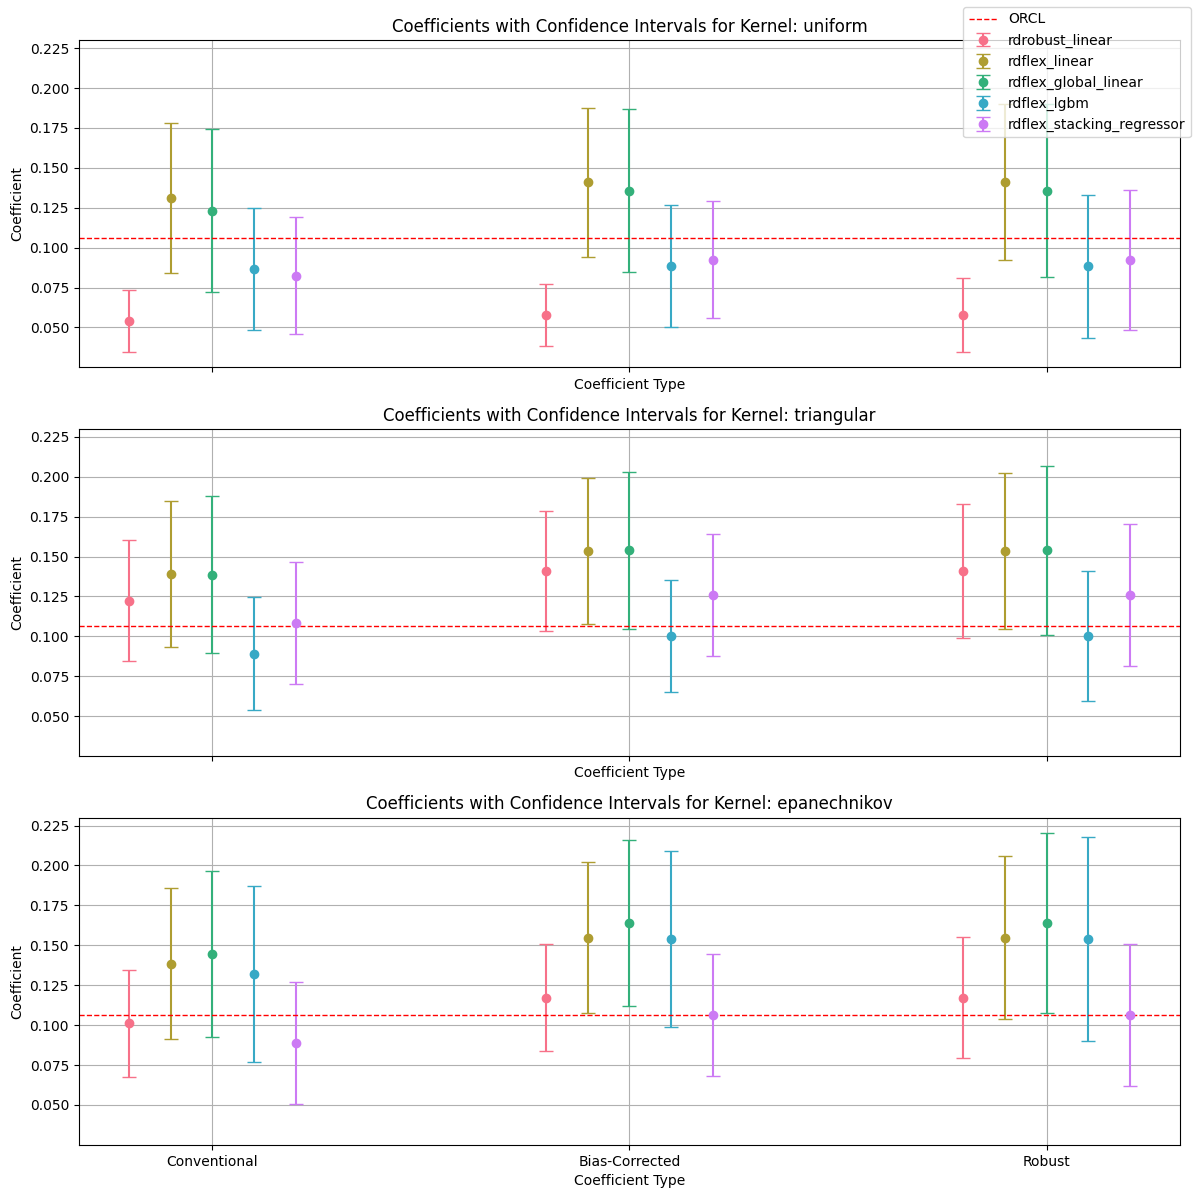

In [22]:
plot_ci(df_fuzzy_single)

c:\Users\svenk\anaconda3\envs\dml_rdd\Lib\site-packages\matplotlib\cbook.py:1762: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

c:\Users\svenk\anaconda3\envs\dml_rdd\Lib\site-packages\matplotlib\cbook.py:1762: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

c:\Users\svenk\anaconda3\envs\dml_rdd\Lib\site-packages\matplotlib\cbook.py:1762: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



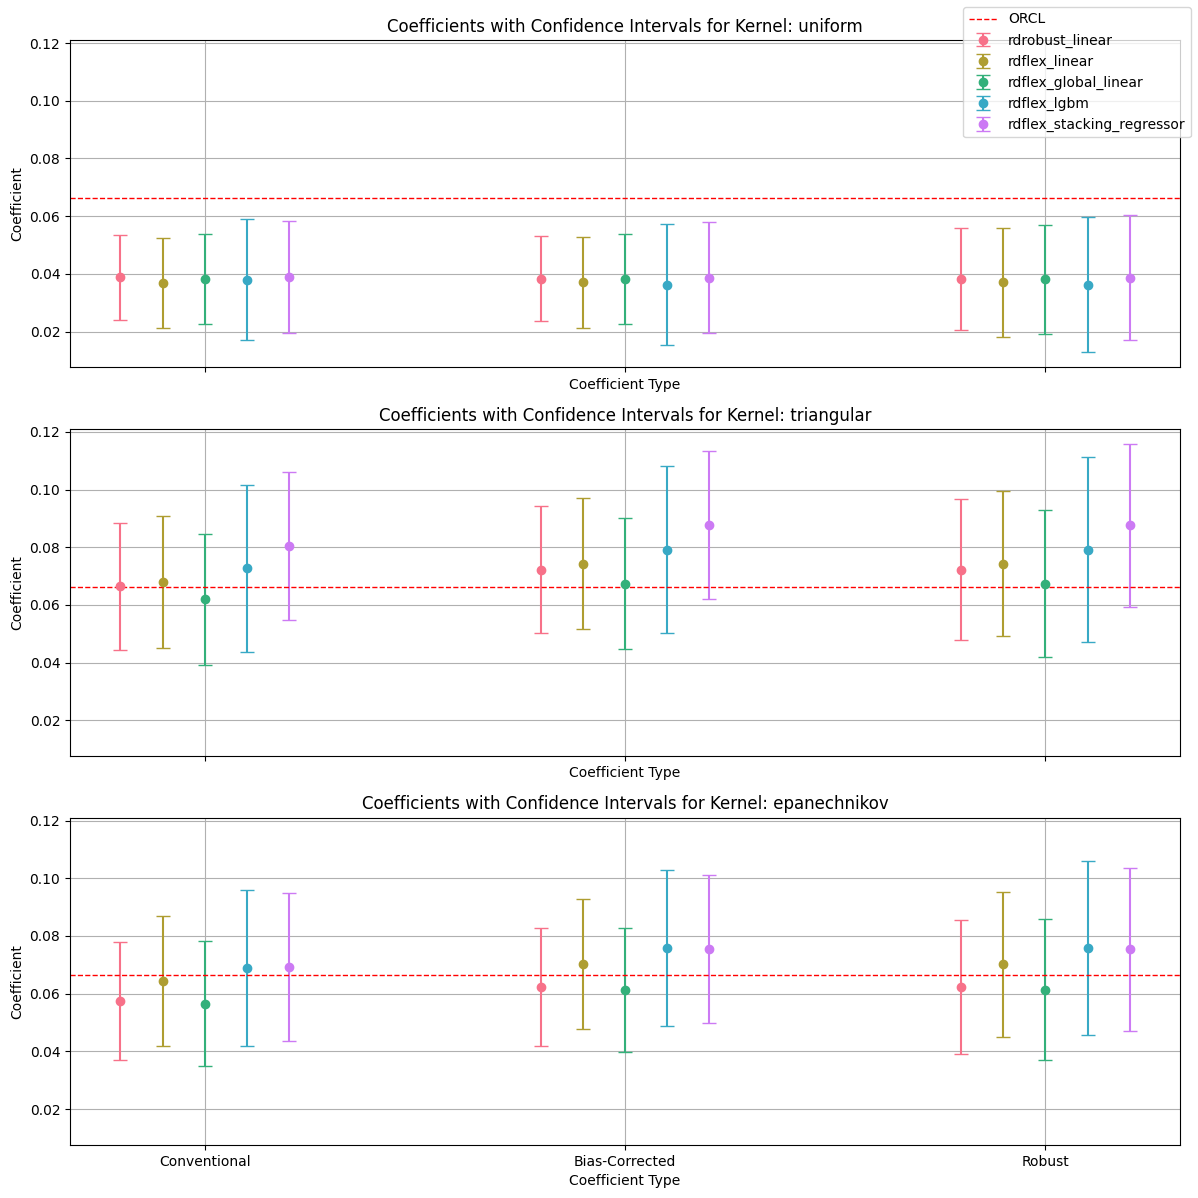

In [23]:
plot_ci(df_intend_single)

In [24]:
def evaluate_results(df):
    coef_types = ["Conventional", "Bias-Corrected", "Robust"]
    
    for coef_type in coef_types:
        df[f"CI width_{coef_type}"] = df[f"upper_ci_{coef_type}"] - df[f"lower_ci_{coef_type}"]
        df[f"Coverage_{coef_type}"] = (df[f"lower_ci_{coef_type}"] <= df["orcl"]) & (df[f"upper_ci_{coef_type}"] >= df["orcl"])
        df[f"centered coef_{coef_type}"] = df[f"coef_{coef_type}"] - df["orcl"]

    output = 80 * "=" + "\n"
    output += (
        f"Coverage:\n {df.groupby(['method', 'learner', 'fs_specification', 'kernel'])[[f"Coverage_{coef_type}" for coef_type in coef_types]].mean()}\n" +
        80 * "=" + "\n" +
        f"Mean CI width:\n {df.groupby(['method', 'learner', 'fs_specification', 'kernel'])[[f"CI width_{coef_type}" for coef_type in coef_types]].mean()}\n" +
        80 * "=" + "\n"
    )

    return df, output

In [25]:
n_rep = 100
n_obs = 5000
fs_specifications = ["cutoff"]
kernels = ["triangular", "uniform"]

res_list_fuzzy = []
res_list_intend = []
for r in range(n_rep):
    clear_output(wait=True)
    
    data_dict = generate_data(r, n_obs=n_obs)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # Fuzzy RDD
        try:
            single_res_fuzzy = estimate_fuzzy(
                r,
                data_dict,
                learner_dict=learner_dict,
                fs_specifications=fs_specifications,
                kernels=kernels,
                cutoff=cutoff)
            res_list_fuzzy.extend(single_res_fuzzy)
        except Exception as e:
                print(f"An error occurred during fuzzy repetition {r}: {e}")

        # Intention to treat RDD
        try:
            single_res_intend = estimate_indend(
                r,
                data_dict,
                learner_dict=learner_dict,
                fs_specifications=fs_specifications,
                kernels=kernels,
                cutoff=cutoff)
            res_list_intend.extend(single_res_intend)
        except Exception as e:
                print(f"An error occurred during intend repetition {r}: {e}")

    df_fuzzy = pd.DataFrame(res_list_fuzzy)
    df_intend = pd.DataFrame(res_list_intend)

    df_fuzzy_res, fuzzy_output = evaluate_results(df_fuzzy)
    df_intend_res, indentd_output = evaluate_results(df_intend)
    combined_output = "Fuzzy\n" + fuzzy_output + "\n ITT \n" + indentd_output
    loop_output = f"Finished iteration {r+1}/{n_rep}\n" + combined_output
    print(loop_output)


Finished iteration 100/100
Fuzzy
Coverage:
                                                          Coverage_Conventional  \
method   learner            fs_specification kernel                              
rdflex   global_linear      cutoff           triangular                   0.84   
                                             uniform                      0.86   
         lgbm               cutoff           triangular                   0.80   
                                             uniform                      0.55   
         linear             cutoff           triangular                   0.82   
                                             uniform                      0.88   
         stacking_regressor cutoff           triangular                   0.92   
                                             uniform                      0.89   
rdrobust linear             cutoff           triangular                   0.76   
                                             uniform  

In [30]:
print(fuzzy_output)


Coverage:
                                                          Coverage_Conventional  \
method   learner            fs_specification kernel                              
rdflex   global_linear      cutoff           triangular                   0.84   
                                             uniform                      0.86   
         lgbm               cutoff           triangular                   0.80   
                                             uniform                      0.55   
         linear             cutoff           triangular                   0.82   
                                             uniform                      0.88   
         stacking_regressor cutoff           triangular                   0.92   
                                             uniform                      0.89   
rdrobust linear             cutoff           triangular                   0.76   
                                             uniform                      0.57   

    

In [31]:
print(indentd_output)

Coverage:
                                                          Coverage_Conventional  \
method   learner            fs_specification kernel                              
rdflex   global_linear      cutoff           triangular                   0.84   
                                             uniform                      0.83   
         lgbm               cutoff           triangular                   0.55   
                                             uniform                      0.15   
         linear             cutoff           triangular                   0.82   
                                             uniform                      0.81   
         stacking_regressor cutoff           triangular                   0.68   
                                             uniform                      0.30   
rdrobust linear             cutoff           triangular                   0.82   
                                             uniform                      0.80   

    